In [1]:
!kaggle datasets download -d mrigaankjaswal/exercise-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/mrigaankjaswal/exercise-detection-dataset
License(s): CC0-1.0
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 26.5MB/s]


In [2]:
!unzip "/content/exercise-detection-dataset.zip" -d "/content/"

Archive:  /content/exercise-detection-dataset.zip
  inflating: /content/exercise_angles.csv  


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [38]:
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [40]:
df = pd.read_csv("/content/exercise_angles.csv")

copy_df = df.copy()

In [41]:
copy_df = df.copy()

In [42]:
# df = copy_df.copy()

In [43]:
df.head()

,Side,Shoulder_Angle,Elbow_Angle,Hip_Angle,Knee_Angle,Ankle_Angle,Shoulder_Ground_Angle,Elbow_Ground_Angle,Hip_Ground_Angle,Knee_Ground_Angle,Ankle_Ground_Angle,Label
0,left,10.639208,174.466813,174.785143,179.848140,179.419276,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
1,left,10.590342,174.428706,174.765042,179.775215,179.386147,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
2,left,10.546746,174.489431,174.785790,179.660017,179.333710,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
3,left,10.487682,174.614913,174.759542,179.614223,179.313926,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
4,left,10.412107,174.758503,174.737721,179.570564,179.298805,90.0,90.0,90.0,90.0,90.0,Jumping Jacks


In [44]:
df.drop(columns = "Side", inplace = True)

In [45]:
df.head()

,Shoulder_Angle,Elbow_Angle,Hip_Angle,Knee_Angle,Ankle_Angle,Shoulder_Ground_Angle,Elbow_Ground_Angle,Hip_Ground_Angle,Knee_Ground_Angle,Ankle_Ground_Angle,Label
0,10.639208,174.466813,174.785143,179.848140,179.419276,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
1,10.590342,174.428706,174.765042,179.775215,179.386147,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
2,10.546746,174.489431,174.785790,179.660017,179.333710,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
3,10.487682,174.614913,174.759542,179.614223,179.313926,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
4,10.412107,174.758503,174.737721,179.570564,179.298805,90.0,90.0,90.0,90.0,90.0,Jumping Jacks


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31033 entries, 0 to 31032
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Shoulder_Angle         31033 non-null  float64
 1   Elbow_Angle            31033 non-null  float64
 2   Hip_Angle              31033 non-null  float64
 3   Knee_Angle             31033 non-null  float64
 4   Ankle_Angle            31033 non-null  float64
 5   Shoulder_Ground_Angle  31033 non-null  float64
 6   Elbow_Ground_Angle     31033 non-null  float64
 7   Hip_Ground_Angle       31033 non-null  float64
 8   Knee_Ground_Angle      31033 non-null  float64
 9   Ankle_Ground_Angle     31033 non-null  float64
 10  Label                  31033 non-null  object 
dtypes: float64(10), object(1)
memory usage: 2.6+ MB


# Feature Selection

In [47]:
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

In [48]:
le.classes_

array(['Jumping Jacks', 'Pull ups', 'Push Ups', 'Russian twists',
       'Squats'], dtype=object)

In [49]:
jump = df[df["Label"] == 0].sample(1000)
pull = df[df["Label"] == 1].sample(1000)
push = df[df["Label"] == 2].sample(1000)
russ = df[df["Label"] == 3].sample(1000)
squats = df[df["Label"] == 4].sample(1000)

In [50]:
test_df = pd.concat([jump, pull, push, russ, squats], ignore_index = False)

In [51]:
test_df.Label.value_counts()

,count
Label,
0,1000
1,1000
2,1000
3,1000
4,1000


In [52]:
test_df = test_df.sample(frac=1, random_state=42)

In [53]:
train_df = df[~df.index.isin(test_df.index)]

In [54]:
train_df.shape

(26033, 11)

In [55]:
X_train, X_test, y_train, y_test = train_df.drop(columns = "Label"), test_df.drop(columns = "Label"), train_df["Label"], test_df["Label"]

### Correlation

<Axes: >

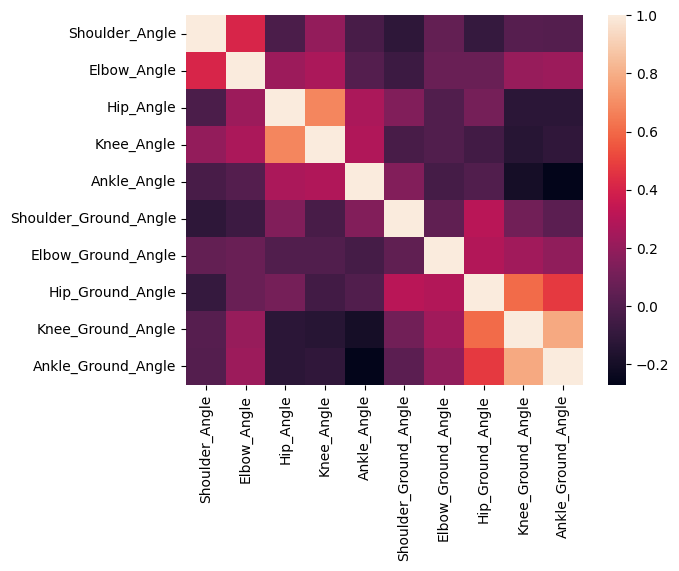

In [56]:
sns.heatmap(X_train.corr())

In [57]:
fi_df1 = train_df.corr()["Label"].reset_index().sort_values("Label", ascending = False).rename(columns = {"index": "feature", "Label":"corr"}).drop(10)

In [58]:
fi_df1

,feature,corr
5,Shoulder_Ground_Angle,0.056541
7,Hip_Ground_Angle,-0.019808
6,Elbow_Ground_Angle,-0.071822
4,Ankle_Angle,-0.072081
8,Knee_Ground_Angle,-0.085187
9,Ankle_Ground_Angle,-0.094886
2,Hip_Angle,-0.348470
0,Shoulder_Angle,-0.410011
3,Knee_Angle,-0.434084
1,Elbow_Angle,-0.482664


### Random Forest's Feature Importance

In [59]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight = "balanced_subsample")
rf.fit(X_train, y_train)

fi_df2 = pd.DataFrame({
    'feature': X_train.columns,
    'rf_importance': rf.feature_importances_
}).sort_values(by = 'rf_importance', ascending = False)

fi_df2

,feature,rf_importance
4,Ankle_Angle,0.271330
2,Hip_Angle,0.191481
0,Shoulder_Angle,0.184397
3,Knee_Angle,0.148083
1,Elbow_Angle,0.145413
9,Ankle_Ground_Angle,0.030665
7,Hip_Ground_Angle,0.014636
8,Knee_Ground_Angle,0.011059
6,Elbow_Ground_Angle,0.002216
5,Shoulder_Ground_Angle,0.000722


### Gradient Boosting's Feature Importance

In [60]:
sample_weights = compute_sample_weight(class_weight = "balanced", y = y_train)

In [61]:
gb = GradientBoostingClassifier(random_state = 42)
gb.fit(X_train, y_train, sample_weight = sample_weights)

fi_df3 = pd.DataFrame({
    'feature': X_train.columns,
    'gb_importance': gb.feature_importances_
}).sort_values(by = 'gb_importance', ascending = False)

fi_df3

,feature,gb_importance
4,Ankle_Angle,0.273004
2,Hip_Angle,0.226192
0,Shoulder_Angle,0.197490
1,Elbow_Angle,0.160880
3,Knee_Angle,0.078962
9,Ankle_Ground_Angle,0.038632
7,Hip_Ground_Angle,0.017608
8,Knee_Ground_Angle,0.003872
6,Elbow_Ground_Angle,0.002516
5,Shoulder_Ground_Angle,0.000845


### Permutation Importance

In [68]:
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

rf3 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight = "balanced")
rf3.fit(X_train_label, y_train_label)

perm_importance = permutation_importance(rf3, X_test_label, y_test_label, n_repeats = 30, random_state = 42)

fi_df4 = pd.DataFrame({
    'feature': X_train.columns,
    'perm_importance': perm_importance.importances_mean
}).sort_values(by = 'perm_importance', ascending = False)

fi_df4

,feature,perm_importance
4,Ankle_Angle,0.443877
0,Shoulder_Angle,0.261545
2,Hip_Angle,0.253870
1,Elbow_Angle,0.168792
3,Knee_Angle,0.159036
9,Ankle_Ground_Angle,0.034524
8,Knee_Ground_Angle,0.017214
7,Hip_Ground_Angle,0.012067
6,Elbow_Ground_Angle,0.000448
5,Shoulder_Ground_Angle,0.000000


### Logistic Regression (Lasso)'s Coefficients

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

lasso = LogisticRegression(penalty = "l1", solver = "liblinear", random_state = 42, class_weight = "balanced")
lasso.fit(X_train_scaled, y_train)

fi_df5 = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso.coef_[0]
}).sort_values(by = 'lasso_coef', ascending = False)

fi_df5

,feature,lasso_coef
4,Ankle_Angle,2.566583
3,Knee_Angle,2.378401
9,Ankle_Ground_Angle,1.501724
1,Elbow_Angle,1.130424
8,Knee_Ground_Angle,0.799622
2,Hip_Angle,0.175721
5,Shoulder_Ground_Angle,0.000000
6,Elbow_Ground_Angle,0.000000
7,Hip_Ground_Angle,0.000000
0,Shoulder_Angle,-0.259888


### Recursive Feature Elimination (RFE)

In [64]:
estimator = RandomForestClassifier(class_weight = "balanced_subsample")

selector_label = RFE(estimator, n_features_to_select = X_train.shape[1], step = 1)
selector_label = selector_label.fit(X_train, y_train)

selected_features = X_train.columns[selector_label.support_]

selected_coefficients = selector_label.estimator_.feature_importances_

fi_df6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_coef': selected_coefficients
}).sort_values(by = 'rfe_coef', ascending = False)

fi_df6

,feature,rfe_coef
4,Ankle_Angle,0.273176
0,Shoulder_Angle,0.189803
2,Hip_Angle,0.180453
3,Knee_Angle,0.150249
1,Elbow_Angle,0.146351
9,Ankle_Ground_Angle,0.030952
7,Hip_Ground_Angle,0.014857
8,Knee_Ground_Angle,0.011430
6,Elbow_Ground_Angle,0.002204
5,Shoulder_Ground_Angle,0.000525


### Logistic Regression's Coefficients

In [65]:
log_reg = LogisticRegression(random_state = 42, max_iter = 1000, class_weight = "balanced")
log_reg.fit(X_train_scaled, y_train)

fi_df7 = pd.DataFrame({
    'feature': X_train.columns,
    'log_reg_coef': log_reg.coef_[0]
}).sort_values(by = 'log_reg_coef', ascending = False)

fi_df7

,feature,log_reg_coef
3,Knee_Angle,1.679788
4,Ankle_Angle,1.277982
9,Ankle_Ground_Angle,1.068131
1,Elbow_Angle,0.901877
2,Hip_Angle,0.804991
0,Shoulder_Angle,0.722680
8,Knee_Ground_Angle,0.510327
7,Hip_Ground_Angle,0.123238
6,Elbow_Ground_Angle,-0.053193
5,Shoulder_Ground_Angle,-0.060503


### Mutual Info

In [66]:
mi = mutual_info_classif(X_train, y_train)

fi_df8 = pd.DataFrame({
    'feature': X_train.columns,
    'mutual_info': mi
}).sort_values(by = 'mutual_info', ascending = False)

fi_df8

,feature,mutual_info
4,Ankle_Angle,0.554679
2,Hip_Angle,0.321535
3,Knee_Angle,0.311514
0,Shoulder_Angle,0.288646
1,Elbow_Angle,0.226042
9,Ankle_Ground_Angle,0.082530
8,Knee_Ground_Angle,0.056533
7,Hip_Ground_Angle,0.041181
5,Shoulder_Ground_Angle,0.011528
6,Elbow_Ground_Angle,0.008323


### Finding Mean Of All The Feature Importances

In [71]:
fi_df = fi_df1.merge(fi_df2, on = "feature").merge(fi_df3, on = "feature").merge(fi_df4, on = "feature").merge(fi_df5, on = "feature").merge(fi_df6, on = "feature").merge(fi_df7, on = "feature").merge(fi_df8, on = "feature")

In [72]:
fi_df

,feature,corr,rf_importance,gb_importance,perm_importance,lasso_coef,rfe_coef,log_reg_coef,mutual_info
0,Shoulder_Ground_Angle,0.056541,0.000722,0.000845,0.000000,0.000000,0.000525,-0.060503,0.011528
1,Hip_Ground_Angle,-0.019808,0.014636,0.017608,0.012067,0.000000,0.014857,0.123238,0.041181
2,Elbow_Ground_Angle,-0.071822,0.002216,0.002516,0.000448,0.000000,0.002204,-0.053193,0.008323
3,Ankle_Angle,-0.072081,0.271330,0.273004,0.443877,2.566583,0.273176,1.277982,0.554679
4,Knee_Ground_Angle,-0.085187,0.011059,0.003872,0.017214,0.799622,0.011430,0.510327,0.056533
5,Ankle_Ground_Angle,-0.094886,0.030665,0.038632,0.034524,1.501724,0.030952,1.068131,0.082530
6,Hip_Angle,-0.348470,0.191481,0.226192,0.253870,0.175721,0.180453,0.804991,0.321535
7,Shoulder_Angle,-0.410011,0.184397,0.197490,0.261545,-0.259888,0.189803,0.722680,0.288646
8,Knee_Angle,-0.434084,0.148083,0.078962,0.159036,2.378401,0.150249,1.679788,0.311514
9,Elbow_Angle,-0.482664,0.145413,0.160880,0.168792,1.130424,0.146351,0.901877,0.226042


In [73]:
fi_df.set_index("feature", inplace = True)

In [74]:
fi_df = fi_df.divide(fi_df.sum(axis = 1), axis = 0)

In [75]:
fi_df

,corr,rf_importance,gb_importance,perm_importance,lasso_coef,rfe_coef,log_reg_coef,mutual_info
feature,,,,,,,,
Shoulder_Ground_Angle,5.855246,0.074740,0.087480,0.000000,0.000000,0.054369,-6.265603,1.193767
Hip_Ground_Angle,-0.097203,0.071821,0.086409,0.059216,0.000000,0.072909,0.604762,0.202086
Elbow_Ground_Angle,0.657057,-0.020272,-0.023015,-0.004100,-0.000000,-0.020163,0.486638,-0.076144
Ankle_Angle,-0.012898,0.048551,0.048851,0.079426,0.459257,0.048881,0.228679,0.099253
Knee_Ground_Angle,-0.064298,0.008347,0.002923,0.012993,0.603547,0.008627,0.385190,0.042671
Ankle_Ground_Angle,-0.035244,0.011390,0.014349,0.012823,0.557791,0.011497,0.396740,0.030654
Hip_Angle,-0.192975,0.106038,0.125260,0.140588,0.097311,0.099931,0.445787,0.178060
Shoulder_Angle,-0.349046,0.156978,0.168125,0.222656,-0.221245,0.161581,0.615223,0.245727
Knee_Angle,-0.097068,0.033114,0.017657,0.035563,0.531849,0.033598,0.375628,0.069660


In [76]:
fi_df.median(axis = 1).sort_values(ascending = False)

,0
feature,
Shoulder_Angle,0.164853
Hip_Angle,0.115649
Hip_Ground_Angle,0.072365
Elbow_Angle,0.068764
Shoulder_Ground_Angle,0.064555
Ankle_Angle,0.064154
Knee_Angle,0.034581
Ankle_Ground_Angle,0.013586
Knee_Ground_Angle,0.010810


In [78]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1000
           1       0.93      0.96      0.95      1000
           2       0.95      0.99      0.97      1000
           3       0.98      0.96      0.97      1000
           4       0.97      0.94      0.95      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



In [79]:
rf.fit(X_train.drop(columns = ["Elbow_Ground_Angle", "Knee_Ground_Angle", "Ankle_Ground_Angle"]), y_train)

y_pred = rf.predict(X_test.drop(columns = ["Elbow_Ground_Angle", "Knee_Ground_Angle", "Ankle_Ground_Angle"]))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.92      0.96      0.94      1000
           2       0.95      0.98      0.97      1000
           3       0.98      0.94      0.96      1000
           4       0.95      0.92      0.93      1000

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



* Even after removing `Elbow_Ground_Angle`, `Knee_Ground_Angle`, and "`Ankle_Ground_Angle`, we are still achieving 95% accuracy.
* There is still room for hyperparameter tuning. I attempted it and reached a maximum of 96% accuracy using Random Forest. You might want to explore other models as well.